Create csv for each glacier that hold glacier-specific water cover info.
- rgi_id
- o1region
- o2region
- total average water covered area in each year (m2)

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025") \
            .sort_values('o2region', ascending=False)

In [25]:
# process each glacier
c=0
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>10: continue

    # grab glacier regions, rgiid, area
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    
    # if o1region!='15': continue
    # if rgi_id != "RGI2000-v7.0-G-13-23966": continue
    
    # print progress
    if c%10==1: print(c, "of", len(rgi_gdf), rgi_id)
    
    # open glacier mask, debris mask
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_mask.tif')
    xr_gmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_mask.tif')
    xr_dmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    xr_gmask = xr_gmask.where(xr_gmask==1)
    xr_dmask = xr_dmask.where(xr_dmask==1)
    
    # open glacier distances
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_distances.tif')
    xr_distance = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    half_distance = np.nanmax(xr_distance)/2
    xr_dmask_terminus = xr.where(xr_distance<=half_distance, 1, 0)
    
    # initialize dictionary to store data
    out_dic = {'rgi_id':rgi_id, 'o1_region':o1region, 'o2_region':o2region,
              }
    
    # open water frequency data, mask to debris
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'glacier_water_frequency_accaqa.tif')
    xr_freq = riox.open_rasterio(path_open, masked=False).astype(float)
    
    # rename bands to the years which they represent
    xr_freq = xr_freq.rename({"band":"year"})
    xr_freq['year'] = [int(i) for i in list(xr_freq.long_name)]
    xr_freq = xr_freq*xr_dmask
    
    ### also open the usable data count info
    path_open = os.path.join(folder_glaciers, rgi_id, 'Usable', 'glacier_usable_count_accaqa.tif')
    xr_usable = riox.open_rasterio(path_open, masked=False).astype(float)
    xr_usable = xr_usable.rename({"band":"year"})
    xr_usable['year'] = [int(i) for i in list(xr_usable.long_name)]
    xr_usable = xr_usable*xr_dmask
    
    # ### lastly, open the water data count info
    # path_open = os.path.join(folder_glaciers, rgi_id, 'glacier_water_count_accaqa.tif')
    # xr_water = riox.open_rasterio(path_open, masked=False).astype(float)
    # xr_water = xr_water.rename({"band":"year"})
    # xr_water['year'] = [int(i) for i in list(xr_water.long_name)]
    # xr_water = xr_water*xr_dmask
    
    
    
    ### apply masking on the annual water frequency timeseries
    # we may want to mask out pixels that have very small numbers of usable obs in a given year
     # and where water frequency very small
    xr_freq_mask = xr_freq.where(xr_usable>3, 0)
    xr_freq_mask = xr_freq_mask.where(xr_freq>0.1, 0)

    # break
    for y in range(1988,2024):
        if y in xr_freq_mask['year']:
            xr_sub = xr_freq_mask.sel(year=y)
            water_sum = int(np.nansum(xr_sub)*30*30)
        else:
            water_sum = np.nan
        
        out_dic[f'water_{y}_m2'] = water_sum
        
    # repeat for terminus data
    xr_freq_term = xr_freq_mask.where(xr_dmask_terminus==1, 0)

    # break
    for y in range(1988,2024):
        if y in xr_freq_term['year']:
            xr_sub = xr_freq_term.sel(year=y)
            water_sum = int(np.nansum(xr_sub)*30*30)
        else:
            water_sum = np.nan
        
        out_dic[f'water_{y}_terminus_m2'] = water_sum
    
    # break
    
    # save out_dic to csv
    out_path = os.path.join(folder_glaciers, rgi_id, 'annual_water_area_frequency_binned_accaqa.csv')
    out_df = pd.Series(out_dic)
    out_df.to_csv(out_path, header=False)

    # break
# break
print("All done!")

1 of 769 RGI2000-v7.0-G-15-18123
11 of 769 RGI2000-v7.0-G-15-14680
21 of 769 RGI2000-v7.0-G-15-18022
31 of 769 RGI2000-v7.0-G-15-17010
41 of 769 RGI2000-v7.0-G-15-07551
51 of 769 RGI2000-v7.0-G-15-07902
61 of 769 RGI2000-v7.0-G-15-08295
71 of 769 RGI2000-v7.0-G-15-06174
81 of 769 RGI2000-v7.0-G-15-08331
91 of 769 RGI2000-v7.0-G-15-06797
101 of 769 RGI2000-v7.0-G-15-09528
111 of 769 RGI2000-v7.0-G-15-09893
121 of 769 RGI2000-v7.0-G-15-11159
131 of 769 RGI2000-v7.0-G-15-08804
141 of 769 RGI2000-v7.0-G-15-08688
151 of 769 RGI2000-v7.0-G-15-09257
161 of 769 RGI2000-v7.0-G-15-01666
171 of 769 RGI2000-v7.0-G-15-01448
181 of 769 RGI2000-v7.0-G-15-01313
191 of 769 RGI2000-v7.0-G-15-01905
201 of 769 RGI2000-v7.0-G-15-00665
211 of 769 RGI2000-v7.0-G-15-00434
221 of 769 RGI2000-v7.0-G-15-00711
231 of 769 RGI2000-v7.0-G-15-00982
241 of 769 RGI2000-v7.0-G-15-02276
251 of 769 RGI2000-v7.0-G-15-05124
261 of 769 RGI2000-v7.0-G-15-05421
271 of 769 RGI2000-v7.0-G-15-02282
281 of 769 RGI2000-v7.0-G-15-05

In [26]:
out_df

rgi_id                    RGI2000-v7.0-G-13-01958
o1_region                                      13
o2_region                                   13-01
water_1988_m2                                 225
water_1989_m2                                3405
                                   ...           
water_2019_terminus_m2                          0
water_2020_terminus_m2                          0
water_2021_terminus_m2                          0
water_2022_terminus_m2                          0
water_2023_terminus_m2                          0
Length: 75, dtype: object

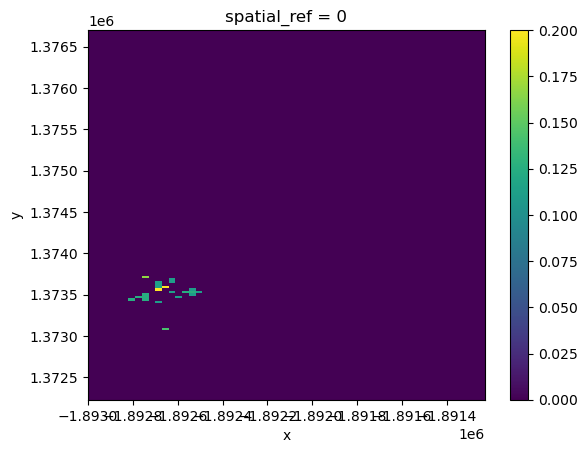

In [27]:
xr_freq_term.sum('year').plot()

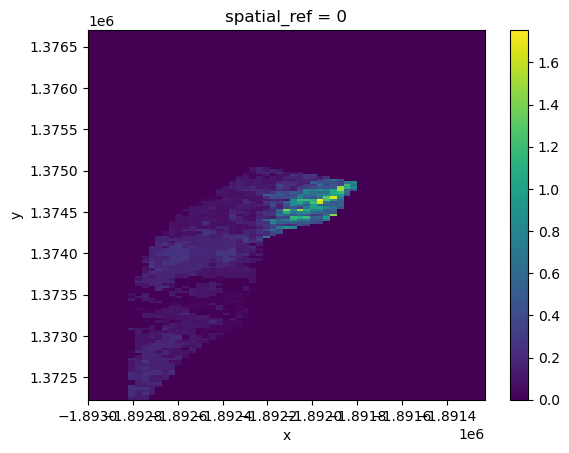

In [28]:
xr_freq.sum('year').plot()